In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import struct
from os.path import join
from array import array
import pickle
import time
import pandas as pd

In [2]:
class NN( ):
    def __init__(self, in_dim, h_dim, out_dim, lr, epochs, lambd = 0, activation = 1, batch_size = None):
        """
        Args:
            in_dim (int): input dimension
            h_dim (int): dimension of the hidden layer
            out_dim (int): output dimension
            lr (float): learning rate
            epochs (int): epochs to train the model
            lambd (float, optional): parameter of the L2 regularization term. Defaults to 0.
            activation (int, optional): 1 corresponds to tanh activations on both layers, 
                                        2 corresponds to ReLU in the first layer and sigmoid in the output layer. Defaults to 1.
            batch_size (int, optional): Batch size for mini-batch gradient descent. Defaults to None.
        Returns: None
        """
        # initailize the weights, using Glorot initialization
        self.W1 = np.random.normal(0, np.sqrt( 2 / (in_dim + h_dim)), (h_dim, in_dim))
        self.W2 = np.random.normal(0, np.sqrt( 2 / (out_dim + h_dim)), (out_dim, h_dim))
        self.b1 = np.zeros((h_dim, 1))
        self.b2 = np.zeros((out_dim, 1))
        self.dims = [in_dim, h_dim, out_dim]
        
        # store the values for backpropagation
        self.cache = {"Z1" : None, "Z2": None, "A1": None, "A2": None}
        
        # store the gradients for update step
        self.grads = {"dW1": None, "dW2": None, "db1": None, "db2": None}
            
        # store the hyperparameters
        self.lr = lr 
        self.lambd = lambd
        self.epochs = epochs
        self.activation = activation
        self.batch_size = batch_size

        # store the loss and accuracy at every step
        self.train_loss = []
        self.test_loss = []
        self.trainaccuracy = []
        self.testaccuracy = []
        
        # self times
        self.forward_time = []
        self.backprop_time = []
        self.update_time = []
        self.train_time = []
        self.test_time = []
        self.cv_time = []
        
        # mistakes
        self.train_mistakes = []
        self.test_mistakes = []
        
    def reset_weights(self):
        """Used to reset the weights for each bootstrap

        Returns: None
        """
        # re-initailize the weights, using Glorot initialization
        self.W1 = np.random.normal(0, np.sqrt( 2 / (self.dims[0] + self.dims[1])), (self.dims[1], self.dims[0]))
        self.W2 = np.random.normal(0, np.sqrt( 2 / (self.dims[2] + self.dims[1])), (self.dims[2], self.dims[1]))
        self.b1 = np.zeros((self.dims[1], 1))
        self.b2 = np.zeros((self.dims[2], 1))
        return None
        
    def sigmoid(self, Z):
        """The sigmoid function

        Args:
            Z(ndarray): pre-activation data

        Returns:
            sigmoid(Z) (ndarray): post-activation data
        """
        return 1 / (1 + np.exp(-Z))
    
    def sigmoid_gradient(self, Z):
        """Gradient of the sigmoid function

        Args:
            Z (ndarray): pre-activation data

        Returns:
            sigmoid'(Z): graident of the sigmoid function evaluated at Z
        """
        return self.sigmoid(Z) * (1 - self.sigmoid(Z))
    
    def relu(self, Z):
        """ReLU activation function

        Args:
            Z (ndarray): pre-activation data

        Returns:
            ReLU(Z): ReLU activation of Z
        """
        return np.maximum(0, Z)
    
    def relu_gradient(self, Z):
        """ReLU gradient

        Args:
            Z (ndarray): pre-activation data

        Returns:
            ReLU(Z): gradient of the ReLU activation of Z
        """
        return np.where(Z > 0, 1, 0)
    
    def tanh_gradient(self, Z):
        """gradient of the tanh function

        Args:
            Z (ndarray): pre-activation data

        Returns:
            tanh(Z): gradient of the tanh activation of Z
        """
        return 1 - (np.tanh(Z) ** 2)
        
    def forward(self, X, predict = False):
        """Forward propagation on the input data X

        Args:
            X (ndarray): input data
            predict (bool, optional): If predict = True, the network returns the output without changing the cache. Defaults to False.

        Returns:
            A2: output of the network, if predict = True, else returns None
        """
        t = time.time()
        if self.activation == 1: # all tanh activation
            #perform forward propagation
            Z1 = (self.W1 @ X) + self.b1
            A1 = np.tanh(Z1)
            Z2 = (self.W2 @ A1) + self.b2
            A2 = np.tanh(Z2)

        
        if self.activation == 2: # relu - sigmoid activation
            #perform forward propagation
            Z1 = (self.W1 @ X) + self.b1
            A1 = self.relu(Z1)
            Z2 = (self.W2 @ A1) + self.b2
            A2 = self.sigmoid(Z2)
        
        if predict: # if predict = True, return the output without changing the cache
            T = time.time()
            self.test_time.append(T - t)
            return A2
        
        # cache the values for backpropagation
        self.cache["A2"] = A2
        self.cache["A1"] = A1
        self.cache["Z2"] = Z2
        self.cache["Z1"] = Z1
        T = time.time()
        # store the forward time
        self.forward_time.append(T - t)
        
        return None
    
    def cost(self, X, Y, whole_data = False):
        """MSE Loss function

        Args:
            X (ndarray): Input data
            Y (ndarray): True labels
            whole_data (bool, optional): If whole_data = True, the function returns the MSE loss on the whole data. Defaults to False. 
                                        (Used for calculating the train loss with mini-batch gradient descent, where the loss is calculated on the whole data, not on the current batch)

        Returns:
            MSE(Y_hat, Y): the MSE loss on the current batch
        """
        if whole_data == False:
            return np.mean( np.linalg.norm((self.cache["A2"] - Y), axis = 0, keepdims = True) ** 2 ) + ( (self.lambd/2) * ((np.linalg.norm(self.W1) ** 2) + (np.linalg.norm(self.W2) ** 2)) )
        if whole_data == True:
            Y_hat = self.forward(X, predict = True)
            return np.mean( np.linalg.norm((Y_hat - Y), axis = 0, keepdims = True) ** 2 ) + ( (self.lambd/2) * ((np.linalg.norm(self.W1) ** 2) + (np.linalg.norm(self.W2) ** 2)) )
        
        
    def train_accuracy(self, X, Y):
        """Calculates the accuracy on the training set

        Args:
            X (ndarray): Input data
            Y (ndarray): True labels

        Returns:
            Accuracy: Accuracy on the training set
        """
        Y_hat = self.forward(X, predict = True)
        return np.mean(np.argmax(Y_hat, axis = 0) == np.argmax(Y, axis = 0))
    
    def mistakes(self, X, Y):
        """Determines the indices of the misclassified samples

        Args:
            X (ndarray): Input data
            Y (ndarray): True labels

        Returns:
            mistakes: (N, ) array of booleans, where N is the number of samples. True if the sample is misclassified, False otherwise
        """
        Y_pred = self.forward(X, predict = True)
        return np.argmax(Y_pred, axis = 0) != np.argmax(Y, axis = 0)
    
    def test_cost_accuracy(self, X, Y):
        """Calculates the test loss and accuracy

        Args:
            X (ndarray): Input data
            Y (ndarray): True labels

        Returns:
            cost (float): MSE loss on the test set
            accuracy (float): Accuracy on the test set
        """
        # get the prediction on X
        Y_test_pred = self.forward(X, predict = True)
        # calculate the cost
        cost = (1/Y.shape[1]) * np.sum( np.linalg.norm((Y_test_pred - Y), axis = 0, keepdims = True) ** 2 ) + ( (self.lambd/2) * ((np.linalg.norm(self.W1) ** 2) + (np.linalg.norm(self.W2) ** 2)) )
        # calculate the accuracy
        accuracy = np.mean(np.argmax(Y_test_pred, axis = 0) == np.argmax(Y, axis = 0))
        return cost, accuracy
    
    def backprop(self, X, Y):
        """Backpropagation on the input data X and true labels Y

        Args:
            X (ndarray): input data
            Y (ndarray): true labels

        Returns:None
        """
        # perform backpropagation
        N = X.shape[1] # number of samples
        t = time.time()
        if self.activation == 1: # all tanh activation
            dZ2 = (2) * ( self.cache["A2"] - Y ) * self.tanh_gradient(self.cache["Z2"])
            dW2 = (1/N) * dZ2 @ self.cache["A1"].T # here /N comes from batch averaging
            db2 = (1/N) * np.sum(dZ2, axis = 1, keepdims = True) # here /N comes from batch averaging
            dZ1 = (self.W2.T @ dZ2) * self.tanh_gradient(self.cache["Z1"])
            dW1 = (1/N) * (dZ1 @ X.T) # here /N comes from batch averaging
            db1 = (1/N) * np.sum(dZ1, axis = 1, keepdims = True) # here /N comes from batch averaging
        
        if self.activation == 2: # relu - sigmoid activation
            dZ2 = (2) * ( self.cache["A2"] - Y ) * self.sigmoid_gradient(self.cache["Z2"])
            dW2 = (1/N) * dZ2 @ self.cache["A1"].T
            db2 = (1/N) * np.sum(dZ2, axis = 1, keepdims = True)
            dZ1 = (self.W2.T @ dZ2) * self.relu_gradient(self.cache["Z1"])
            dW1 = (1/N) * (dZ1 @ X.T)
            db1 = (1/N) * np.sum(dZ1, axis = 1, keepdims = True) 
        self.grads["dW1"] = dW1
        self.grads["dW2"] = dW2
        self.grads["db1"] = db1
        self.grads["db2"] = db2
        self.grads["dZ1"] = dZ1
        T = time.time()
        self.backprop_time.append( T - t ) 
        return None
    
    def update(self):
        """Update the weights of the matrix

        Returns:
            None
        """
        # update the weights
        t = time.time()
        self.W1 = self.W1 - self.lr * self.grads["dW1"]
        self.W2 = self.W2 - self.lr * self.grads["dW2"]
        self.b1 = self.b1 - self.lr * self.grads["db1"]
        self.b2 = self.b2 - self.lr * self.grads["db2"]
        T = time.time()
        # store the update time
        self.update_time.append(T - t)
        return None
    
    def train(self, X, Y, X_test, Y_test, lambd = 0):
        """Train the model

        Args:
            X (ndarray): training data 
            Y (ndarray): true labels for the training data
            X_test (ndarray): test data
            Y_test (_type_): true labels for the test data
            lambd (float, optional): L2 regularization parameter. Defaults to 0.

        Returns:
            None
        """
        t = time.time()
        # if mini-batch training
        mini_batch = self.batch_size
        #reset the training and test metrics
        self.train_loss = []
        self.trainaccuracy = []
        self.test_loss = []
        self.testaccuracy = []
        self.train_mistakes = []
        
        # if training offline
        if mini_batch is None: 
            for e in range(self.epochs):
                # run the training
                self.forward(X)
                self.backprop(X, Y)
                self.update()
                # save the loss and accuracy
                self.train_loss.append(self.cost(X, Y))
                self.trainaccuracy.append(self.train_accuracy(X, Y))
                
                if (e+1) % 10 == 0: # at every then epochs, calculate the test loss and accuracy
                    testcost, testaccuracy = self.test_cost_accuracy(X_test, Y_test)
                    self.test_loss.append(testcost)
                    self.testaccuracy.append(testaccuracy)
                    print("Epoch: ", e, "Loss: ", self.train_loss[-1], "Accuracy: ", self.trainaccuracy[-1], "Test Loss: ", self.test_loss[-1], "Test Accuracy: ", self.testaccuracy[-1])
        
        # if mini-batch training
        if mini_batch is not None:
            for e in range(self.epochs):
                # shuffle the data
                shuffled_indices = np.random.permutation(X.shape[1])
                batch_count = ( X.shape[1] // mini_batch ) 
                for i in range(batch_count):
                    # last batch = all the rest
                    if i == batch_count - 1:
                        batch_indices = shuffled_indices[i*mini_batch:]
                    # other batches
                    else:
                        batch_indices = shuffled_indices[i*mini_batch:(i+1)*mini_batch]
                    # get the batch
                    X_batch = X[:, batch_indices]
                    Y_batch = Y[:, batch_indices]
                    # run the training
                    self.forward(X_batch)
                    self.backprop(X_batch, Y_batch)
                    self.update()
                # save the loss and accuracy
                self.train_loss.append(self.cost(X, Y, whole_data = True))
                self.trainaccuracy.append(self.train_accuracy(X, Y))

                if (e+1) % 10 == 0: # at every then epochs, calculate the test loss and accuracy
                    testcost, testaccuracy = self.test_cost_accuracy(X_test, Y_test)
                    self.test_loss.append(testcost)
                    self.testaccuracy.append(testaccuracy)
                    print("Epoch: ", (e+1), "Loss: ", self.train_loss[-1], "Accuracy: ", self.trainaccuracy[-1], "Test Loss: ", self.test_loss[-1], "Test Accuracy: ", self.testaccuracy[-1])
        # save the time
        T = time.time()
        self.train_mistakes.append(self.mistakes(X, Y))
        self.test_mistakes.append(self.mistakes(X_test, Y_test))
        self.train_time.append(T - t)
        return None
    
    
    def bootstrap(self, X, Y, X_test, Y_test, lambd = 0, n = 10):
        """n-fold bootstrap validation

        Args:
            X (ndarray): training data 
            Y (ndarray): true labels for the training data
            X_test (ndarray): test data
            Y_test (_type_): true labels for the test data
            lambd (float, optional): L2 regularization parameter. Defaults to 0.
            n (int, optional): fold number for bootstrapping. Defaults to 10.
        """
        # save the loss and accuracy for each bootstrap
        self.bootstrap_cost = []
        self.bootstrap_accuracy = []
        
        # merge the train and test sets
        X_shuffled = np.concatenate((X, X_test), axis = 1)
        Y_shuffled = np.concatenate((Y, Y_test), axis = 1)
        
        # shuffle the data
        shuffled_indices = np.random.permutation(X_shuffled.shape[1])
        X_shuffled = X_shuffled[:, shuffled_indices]
        Y_shuffled = Y_shuffled[:, shuffled_indices]
        
        t = time.time()
        for i in range(n):
            # split the data into train and test sets using the shuffled indices
            bscost = []
            bsaccuracy = []
            if i != n-1: # if not the last iteration
                test_indices = shuffled_indices[(X_shuffled.shape[1] // n) * i : (X_shuffled.shape[1] // n) * (i+1)]
                train_indices = np.ones(X_shuffled.shape[1], dtype=bool)
                train_indices[test_indices] = False
                
                X_bootstrap_train = X_shuffled[:, train_indices]
                Y_bootstrap_train = Y_shuffled[:, train_indices]
                X_bootstrap_test = X_shuffled[:, test_indices]
                Y_bootstrap_test = Y_shuffled[:, test_indices]
                
            if i == n-1: # if the last iteration, use all the remaining data
                test_indices = shuffled_indices[(X_shuffled.shape[1] // n) * i : ]
                train_indices = np.ones(X_shuffled.shape[1], dtype=bool)
                train_indices[test_indices] = False

                X_bootstrap_train = X_shuffled[:, train_indices]
                Y_bootstrap_train = Y_shuffled[:, train_indices]
                X_bootstrap_test = X_shuffled[:, test_indices]
                Y_bootstrap_test = Y_shuffled[:, test_indices]
            
            self.reset_weights(self) # reset the weights for each bootstrap
            
            for e in range(self.epochs): # train the model
                # run the training
                self.forward(X_bootstrap_train)
                self.backprop(X_bootstrap_train, Y_bootstrap_train)
                self.update()
                # save the loss and accuracy
                self.train_loss.append(self.cost(X_bootstrap_train, Y_bootstrap_train))
                self.trainaccuracy.append(self.train_accuracy(Y_bootstrap_train))
                if e % 10 == 0: # at every ten epochs, calculate the test loss and accuracy
                    testcost, testaccuracy = self.test_cost_accuracy(X_bootstrap_test, Y_bootstrap_test)
                    self.test_loss.append(testcost)
                    self.testaccuracy.append(testaccuracy)
            # save the loss and accuracy for each bootstrap
            bscost, bsaccuracy = self.test_cost_accuracy(X_bootstrap_test, Y_bootstrap_test)
            self.bootstrap_cost.append(bscost)
            self.bootstrap_accuracy.append(bsaccuracy)
            T = time.time()
            self.cv_time.append(T - t)
            print("Bootstrap: ", i, "Loss: ", self.bootstrap_cost[-1], "Accuracy: ", self.bootstrap_accuracy[-1])
                    
        
    def plot_loss(self):
        """Plots the loss data for the training and test sets

        Returns:
            _type_: _description_
        """
        # plot the loss
        plt.plot(self.train_loss)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Loss vs Epochs")
        plt.show()
        return None
    
    def plot_accuracy(self):
        """Plots the accuracy data"""
        plt.plot(self.train_accuracy)
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title("Accuracy vs Epochs")
        plt.show()
        return None

In [3]:
# method for loading the data from the MNIST dataset
def load_mnist_data(imagepath, labelpath):
            
    labels = []
    # read the labels
    with open(labelpath, 'rb') as file:
        # read the magic number
        mnumber, size = struct.unpack(">II", file.read(8))
        if mnumber != 2049: # check the magic number
            # raise an error if the magic number is not correct
            raise ValueError(f'Magic number mismatch, expected 2049, got {mnumber}')
        # read the labels
        labels = array("B", file.read())        
    
    with open(imagepath, 'rb') as file: # read the images
        # read the magic number, number of images, rows and columns
        mnumber, size, rows, cols = struct.unpack(">IIII", file.read(16))
        if mnumber != 2051: # check the magic number
            # raise an error if the magic number is not correct
            raise ValueError(f'Magic number mismatch, expected 2051, got {mnumber}')
        # read the image data
        image_data = array("B", file.read())  
    
    images = []
    for i in range(size):
        # create an empty array for each image
        images.append([0] * rows * cols)
    for i in range(size):
        # fill the array with the image data
        img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
        img = img.reshape(28, 28)
        images[i][:] = img            
    
    return np.array(images), np.array(labels)
        

In [4]:
# retrieve the data
training_image_path = "MNIST/train-images-idx3-ubyte/train-images-idx3-ubyte"
training_label_path = "MNIST/train-labels-idx1-ubyte/train-labels-idx1-ubyte"
test_image_path = "MNIST/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte"
test_label_path = "MNIST/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte"

X_train_raw, Y_train_raw = load_mnist_data(training_image_path, training_label_path)
X_test_raw, Y_test_raw = load_mnist_data(test_image_path, test_label_path)

(60000, 28, 28)
(60000,)


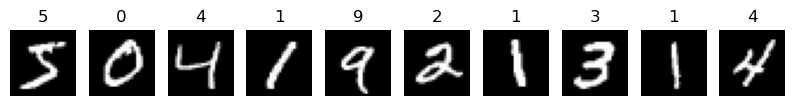

In [5]:
# display a sample of the data 
print(X_train_raw.shape)
print(Y_train_raw.shape)

# plot the first 10 images in X_train together with labels in Y_train
fig, axes = plt.subplots(1, 10, figsize = (10, 10))
for i in range(10):
    axes[i].imshow(X_train_raw[i], cmap = 'gray')
    axes[i].axis('off')
    axes[i].set_title(Y_train_raw[i])
plt.show()

In [6]:
# methods for data preprocessing
def flatten(X):
    return X.reshape(X.shape[0], -1).T # -1 means the dimension is inferred from the remaining dimensions

def normalize(X):
    return X / 255 # 255 is the maximum value of a pixel

def one_hot(Y):
    return np.eye(10)[Y].T # 10 is the number of classes

def preprocess(X, Y):
    """Preprocess the data

    Args:
        X (ndarray): raw input data
        Y (ndarray): raw true labels

    Returns:
        X (ndarray): flattened and normalized input data
        Y (ndarray): one-hot encoded true labels (10, N) array
    """
    X = flatten(X)
    X = normalize(X)
    Y = one_hot(Y)
    return X, Y

In [ ]:
# preprocess the data
X_train, Y_train = preprocess(X_train_raw, Y_train_raw)
X_test, Y_test = preprocess(X_test_raw, Y_test_raw)

In [8]:
# model parameters
input_dim = X_train.shape[0] # 784
hidden_dim = [300, 500, 1000] 
output_dim = Y_train.shape[0] # 10

lr = [0.01, 0.05, 0.09]
nonlinearity = [1, 2] # 1 
epochs = 100

In [ ]:
# for hyperparameter tuning, we will create a dictionary of models with every combination of hyperparameters
models = {}
for h in hidden_dim:
    for rate in lr:
        for n in nonlinearity:
            models[(h, rate, n)] = NN(input_dim, h, output_dim, rate, epochs, activation = n)
            
# now, we train all models with the given dataset, without regularization or mini-batch gradient descent
for model in models.values():
    print("Training model with hidden dimension: ", model.W1.shape[0], "learning rate: ", model.lr, "and activation: ", model.activation)
    model.train(X_train, Y_train, X_test, Y_test)

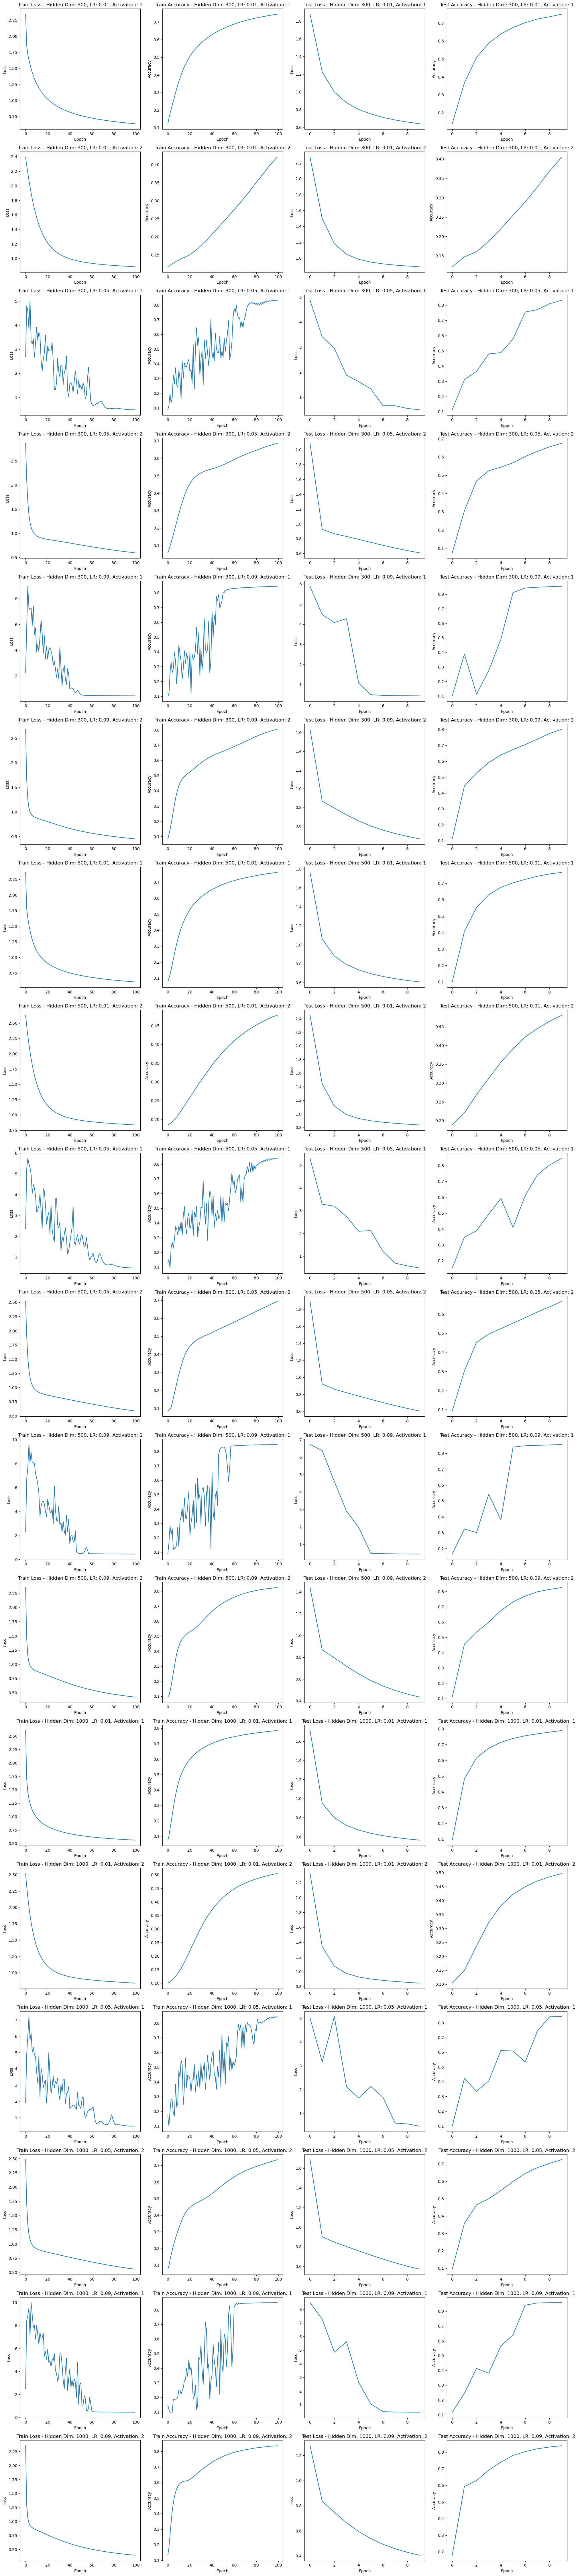

In [58]:
# plot the loss and accuracy for each model

# define the grid of plots
fig, axs = plt.subplots(len(models), 4, figsize=(20, 5*len(models)))

# loop through each model and plot the train/test loss/accuracy
for i, ((h, rate, n), model) in enumerate(models.items()):
    # plot the train loss
    axs[i, 0].plot(model.train_loss)
    axs[i, 0].set_title(f"Train Loss - Hidden Dim: {h}, LR: {rate}, Activation: {n}")
    axs[i, 0].set_xlabel("Epoch")
    axs[i, 0].set_ylabel("Loss")
    
    # plot the train accuracy
    axs[i, 1].plot(model.trainaccuracy)
    axs[i, 1].set_title(f"Train Accuracy - Hidden Dim: {h}, LR: {rate}, Activation: {n}")
    axs[i, 1].set_xlabel("Epoch")
    axs[i, 1].set_ylabel("Accuracy")
    
    # plot the test loss
    axs[i, 2].plot(model.test_loss)
    axs[i, 2].set_title(f"Test Loss - Hidden Dim: {h}, LR: {rate}, Activation: {n}")
    axs[i, 2].set_xlabel("Epoch")
    axs[i, 2].set_ylabel("Loss")
    
    # plot the test accuracy
    axs[i, 3].plot(model.testaccuracy)
    axs[i, 3].set_title(f"Test Accuracy - Hidden Dim: {h}, LR: {rate}, Activation: {n}")
    axs[i, 3].set_xlabel("Epoch")
    axs[i, 3].set_ylabel("Accuracy")
    
plt.tight_layout()
plt.show()


In [14]:
# Evaluate the models 

# create a list of tuples containing the model and its test error
model_accs = [(config, model, model.testaccuracy[-1]) for config, model in models.items()]

# sort the list by test error
model_accs_sorted = sorted(model_accs, key=lambda x: x[2], reverse=True)

# store parameters of the best performing three models wrt to test accuracy
candidate_models = []
for i in range(3):
    config, model, accuracy = model_accs_sorted[i]
    candidate_models.append((model, config, accuracy))
    
# print the sorted list with accompanying metrics
for _, model, loss in model_accs_sorted:
    print(f"Model with hidden dimension {model.W1.shape[0]}, learning rate {model.lr}, and activation {model.activation} has test {model.test_loss[-1]:.4f}")
    print(f"Final train loss: {model.train_loss[-1]:.4f}, final train accuracy: {model.trainaccuracy[-1]:.4f}")
    print(f"Final test accuracy: {model.testaccuracy[-1]:.4f}\n")


Model with hidden dimension 1000, learning rate 0.09, and activation 1 has test 0.4411
Final train loss: 0.4444, final train accuracy: 0.8488
Final test accuracy: 0.8573

Model with hidden dimension 500, learning rate 0.09, and activation 1 has test 0.4471
Final train loss: 0.4493, final train accuracy: 0.8489
Final test accuracy: 0.8554

Model with hidden dimension 300, learning rate 0.09, and activation 1 has test 0.4517
Final train loss: 0.4540, final train accuracy: 0.8435
Final test accuracy: 0.8541

Model with hidden dimension 500, learning rate 0.05, and activation 1 has test 0.4828
Final train loss: 0.4742, final train accuracy: 0.8385
Final test accuracy: 0.8447

Model with hidden dimension 1000, learning rate 0.05, and activation 1 has test 0.4754
Final train loss: 0.4613, final train accuracy: 0.8391
Final test accuracy: 0.8415

Model with hidden dimension 1000, learning rate 0.09, and activation 2 has test 0.4048
Final train loss: 0.3970, final train accuracy: 0.8371
Final 

In [15]:
# Evaluate the training behavior of the models by calculating the half-time of terminal test accuracy

# define the dictionaries to store the approximate epoch at which the train and test accuracy has reached half of their value at epoch=100
train_half_epoch = {}
test_half_epoch = {}

# loop through each model and calculate the approximate epoch at which the train and test accuracy has reached half of their value at epoch=100
for model, config, accuracy in candidate_models:
    # calculate the approximate epoch at which the train accuracy has reached half of its value at epoch=100
    train_half_epoch[config] = next((i for i, acc in enumerate(model.trainaccuracy) if acc >= (model.trainaccuracy[-1]/2)), None)
    
    # calculate the approximate epoch at which the test accuracy has reached half of its value at epoch=100
    test_half_epoch[config] = next((i for i, acc in enumerate(model.testaccuracy) if acc >= (model.testaccuracy[-1]/2)), None)

# print the dictionaries
print("Train Half Epochs:", train_half_epoch)
print("Test Half Epochs:", test_half_epoch)


Train Half Epochs: {(1000, 0.09, 1): 19, (500, 0.09, 1): 15, (300, 0.09, 1): 10}
Test Half Epochs: {(1000, 0.09, 1): 4, (500, 0.09, 1): 3, (300, 0.09, 1): 4}


Training model with hidden dimension:  1000 learning rate:  0.09 and activation:  1
Bootstrap:  0 Loss:  0.44258825064041585 Accuracy:  0.8507142857142858
Bootstrap:  1 Loss:  0.4413659178364262 Accuracy:  0.8491428571428571
Bootstrap:  2 Loss:  0.44636081354962676 Accuracy:  0.8428571428571429
Bootstrap:  3 Loss:  0.4441323689806516 Accuracy:  0.8505714285714285
Bootstrap:  4 Loss:  0.44226599323016896 Accuracy:  0.8482857142857143
Bootstrap:  5 Loss:  0.44192695385924047 Accuracy:  0.8488571428571429
Bootstrap:  6 Loss:  0.446226252108418 Accuracy:  0.848
Bootstrap:  7 Loss:  0.44439830855064705 Accuracy:  0.8515714285714285
Bootstrap:  8 Loss:  0.4466473573633114 Accuracy:  0.8478571428571429
Bootstrap:  9 Loss:  0.44367004357548845 Accuracy:  0.8471428571428572
Training model with hidden dimension:  500 learning rate:  0.09 and activation:  1
Bootstrap:  0 Loss:  0.4487959231492499 Accuracy:  0.8471428571428572
Bootstrap:  1 Loss:  0.45440270132873245 Accuracy:  0.845
Bootstrap:  2

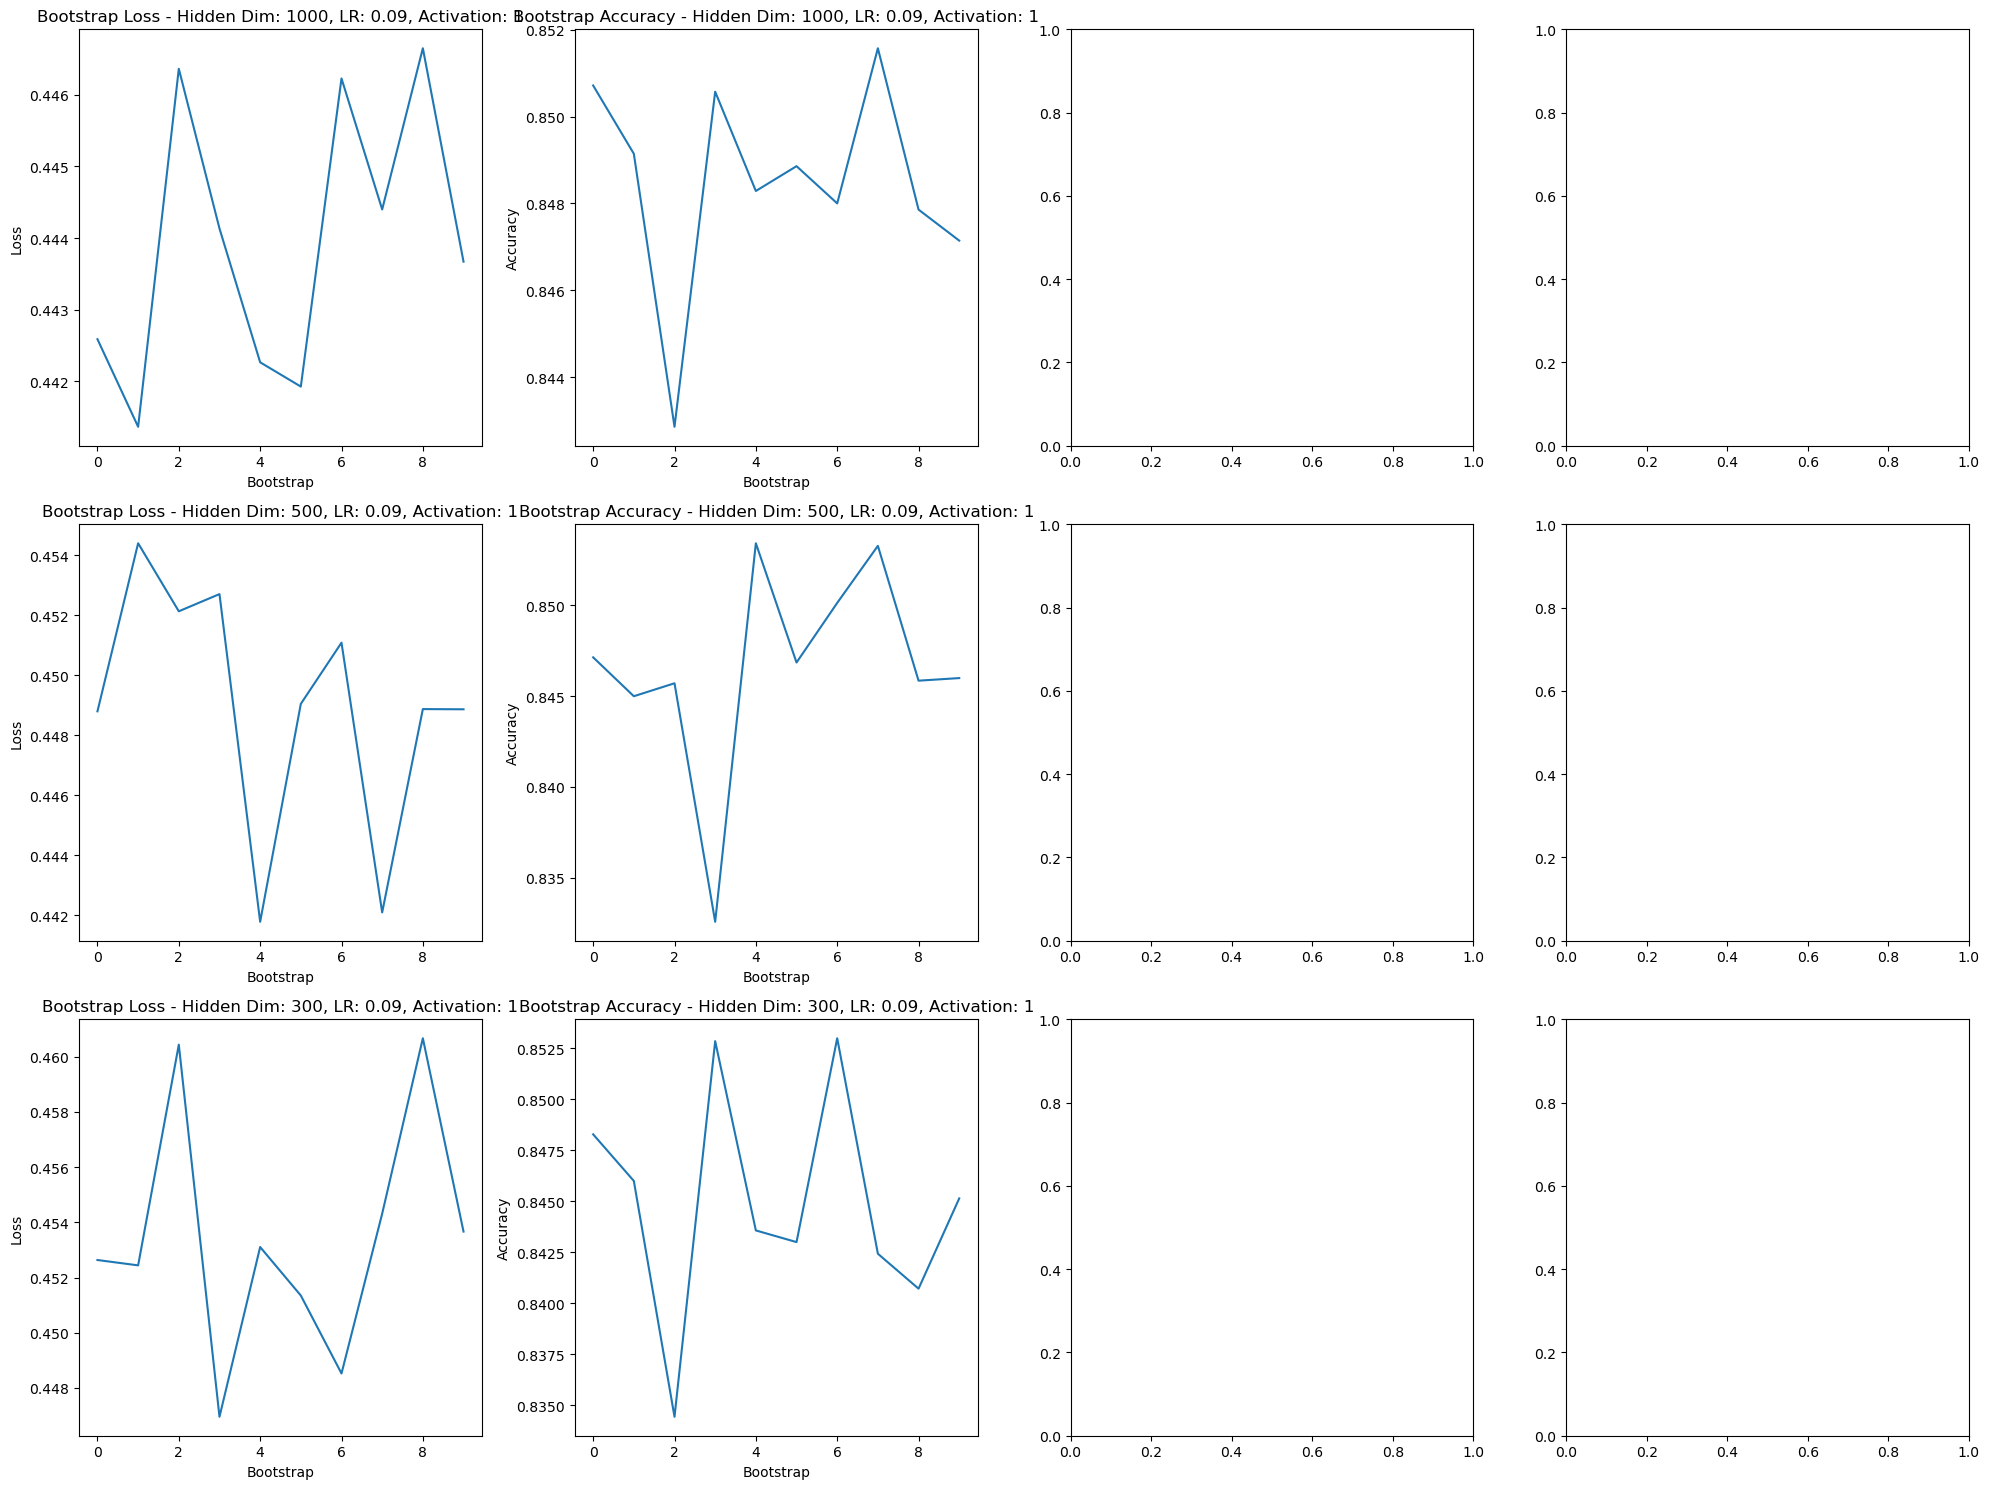

In [16]:
# Cross-validation to find the best model

#generate a new dictionary of models with the same hyperparameters as the candidate models
bootstrap_models = {}

# in the cost/accuracy plots, we observe that the test accuracy is very close to but does not exactly reach the equilibrium value at epoch=100
# so epochs = 100 is a good choice for the number of epochs to train the models with bootstrap

for model, config, accuracy in candidate_models:
    bootstrap_models[config] = NN(input_dim, config[0], output_dim, config[1], epochs, activation = config[2])
    
# train the models with bootstrap
for model in bootstrap_models.values():
    print("Training model with hidden dimension: ", model.W1.shape[0], "learning rate: ", model.lr, "and activation: ", model.activation)
    model.bootstrap(X_train, Y_train, X_test, Y_test, n = 10)
    
# define the grid of plots
fig, axs = plt.subplots(len(bootstrap_models), 4, figsize=(20, 5*len(bootstrap_models)))

# loop through each model and plot the train/test loss/accuracy
for i, ((h, rate, n), model) in enumerate(bootstrap_models.items()):
    # plot the train loss
    axs[i, 0].plot(model.bootstrap_cost)
    axs[i, 0].set_title(f"Bootstrap Loss - Hidden Dim: {h}, LR: {rate}, Activation: {n}")
    axs[i, 0].set_xlabel("Bootstrap")
    axs[i, 0].set_ylabel("Loss")
    
    # plot the train accuracy
    axs[i, 1].plot(model.bootstrap_accuracy)
    axs[i, 1].set_title(f"Bootstrap Accuracy - Hidden Dim: {h}, LR: {rate}, Activation: {n}")
    axs[i, 1].set_xlabel("Bootstrap")
    axs[i, 1].set_ylabel("Accuracy")    
    
plt.tight_layout()

bootstrap_loss = {key: model.bootstrap_cost for key, model in bootstrap_models.items()}
bootstrap_accuracy = {key: model.bootstrap_accuracy for key, model in bootstrap_models.items()}

bootstrap_loss_stats = {key: (np.mean(value), np.std(value)) for key, value in bootstrap_loss.items()}
bootstrap_accuracy_stats = {key: (np.mean(value), np.std(value)) for key, value in bootstrap_accuracy.items()}

#find the model with the lowest mean bootstrap loss
best_config = None
best_acc = 0
for key in bootstrap_accuracy_stats.keys():
    if bootstrap_accuracy_stats[key][0] >= best_acc:
        best_acc = bootstrap_accuracy_stats[key][0]
        best_config = key
    
print(f"Model with hidden dimension {best_config[0]}, learning rate {best_config[1]}, and activation {best_config[2]} has the highest bootstrap accuracy of {bootstrap_accuracy_stats[best_config][0]:.4f} with standard deviation {bootstrap_accuracy_stats[best_config][1]:.4f}")

In [17]:
# Evaluate the bootstrap results

bootstrap_loss = {key: model.bootstrap_cost for key, model in bootstrap_models.items()}
bootstrap_accuracy = {key: model.bootstrap_accuracy for key, model in bootstrap_models.items()}

# get the mean and standard deviation of the bootstrap loss and accuracy
bootstrap_loss_stats = {key: (np.mean(value), np.std(value)) for key, value in bootstrap_loss.items()}
bootstrap_accuracy_stats = {key: (np.mean(value), np.std(value)) for key, value in bootstrap_accuracy.items()}

# find the model with the highest bootstrap accuracy
best_config = None
best_acc = 0
for key in bootstrap_accuracy_stats.keys():
    if bootstrap_accuracy_stats[key][0] >= best_acc:
        best_acc = bootstrap_accuracy_stats[key][0]
        best_config = key

print(f"Model with hidden dimension {best_config[0]}, learning rate {best_config[1]}, and activation {best_config[2]} has the highest bootstrap accuracy of {bootstrap_accuracy_stats[best_config][0]:.4f} with standard deviation {bootstrap_accuracy_stats[best_config][1]:.4f}")

# validate the above result by finding the model with the lowest bootstrap loss
best_config_loss = None
best_loss = float("inf")
for key in bootstrap_loss_stats.keys():
    if bootstrap_loss_stats[key][0] <= best_loss:
        best_loss = bootstrap_loss_stats[key][0]
        best_config_loss = key

print(f"Model with hidden dimension {best_config_loss[0]}, learning rate {best_config_loss[1]}, and activation {best_config_loss[2]} has the lowest mean loss of {bootstrap_loss_stats[best_config_loss][0]:.4f} with standard deviation {bootstrap_loss_stats[best_config_loss][1]:.4f}")

print("Bootstrap loss stats:", bootstrap_loss_stats, "Bootstrap accuracy stats.", bootstrap_accuracy_stats)

Model with hidden dimension 1000, learning rate 0.09, and activation 1 has the highest bootstrap accuracy of 0.8485 with standard deviation 0.0023
Model with hidden dimension 1000, learning rate 0.09, and activation 1 has the lowest mean loss of 0.4440 with standard deviation 0.0018
Bootstrap loss stats: {(1000, 0.09, 1): (0.44395822596943946, 0.0018450327029090484), (500, 0.09, 1): (0.4489764305907129, 0.0039646418562864095), (300, 0.09, 1): (0.45340848797529254, 0.004175043013549295)} Bootstrap accuracy stats. {(1000, 0.09, 1): (0.8484999999999999, 0.002314329805576454), (500, 0.09, 1): (0.8465999999999999, 0.005525377445783003), (300, 0.09, 1): (0.8449428571428571, 0.0052942787757259335)}


In [ ]:
# Train the best model with the given mini-batch sizes

# define the mini-batch sizes and create a dictionary of models with each mini-batch size
mini_batch_sizes = [10, 50, 100]
mini_batch_models = {(best_config[0], best_config[1], best_config[2], size): NN(input_dim, best_config[0], output_dim, best_config[1], epochs, activation = best_config[2], batch_size = size) for size in mini_batch_sizes}

# train the models with the given mini-batch sizes
for model in mini_batch_models.values():
    print("Training model with hidden dimension: ", model.W1.shape[0], "learning rate: ", model.lr, "and activation: ", model.activation)
    model.train(X_train, Y_train, X_test, Y_test)

#find the model with the highest test accuracy
best_mini_batch_size = None
best_acc = 0
for key in mini_batch_models.keys():
    if mini_batch_models[key].testaccuracy[-1] >= best_acc:
        best_acc = mini_batch_models[key].testaccuracy[-1] 
        best_config_mini_batch = key 

Model with hidden dimension 1000, learning rate 0.09, activation 1 and mini-batch size 100 has the highest test accuracy of 0.9511


C:\Users\Ozan\AppData\Local\Temp\ipykernel_12296\4098794942.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


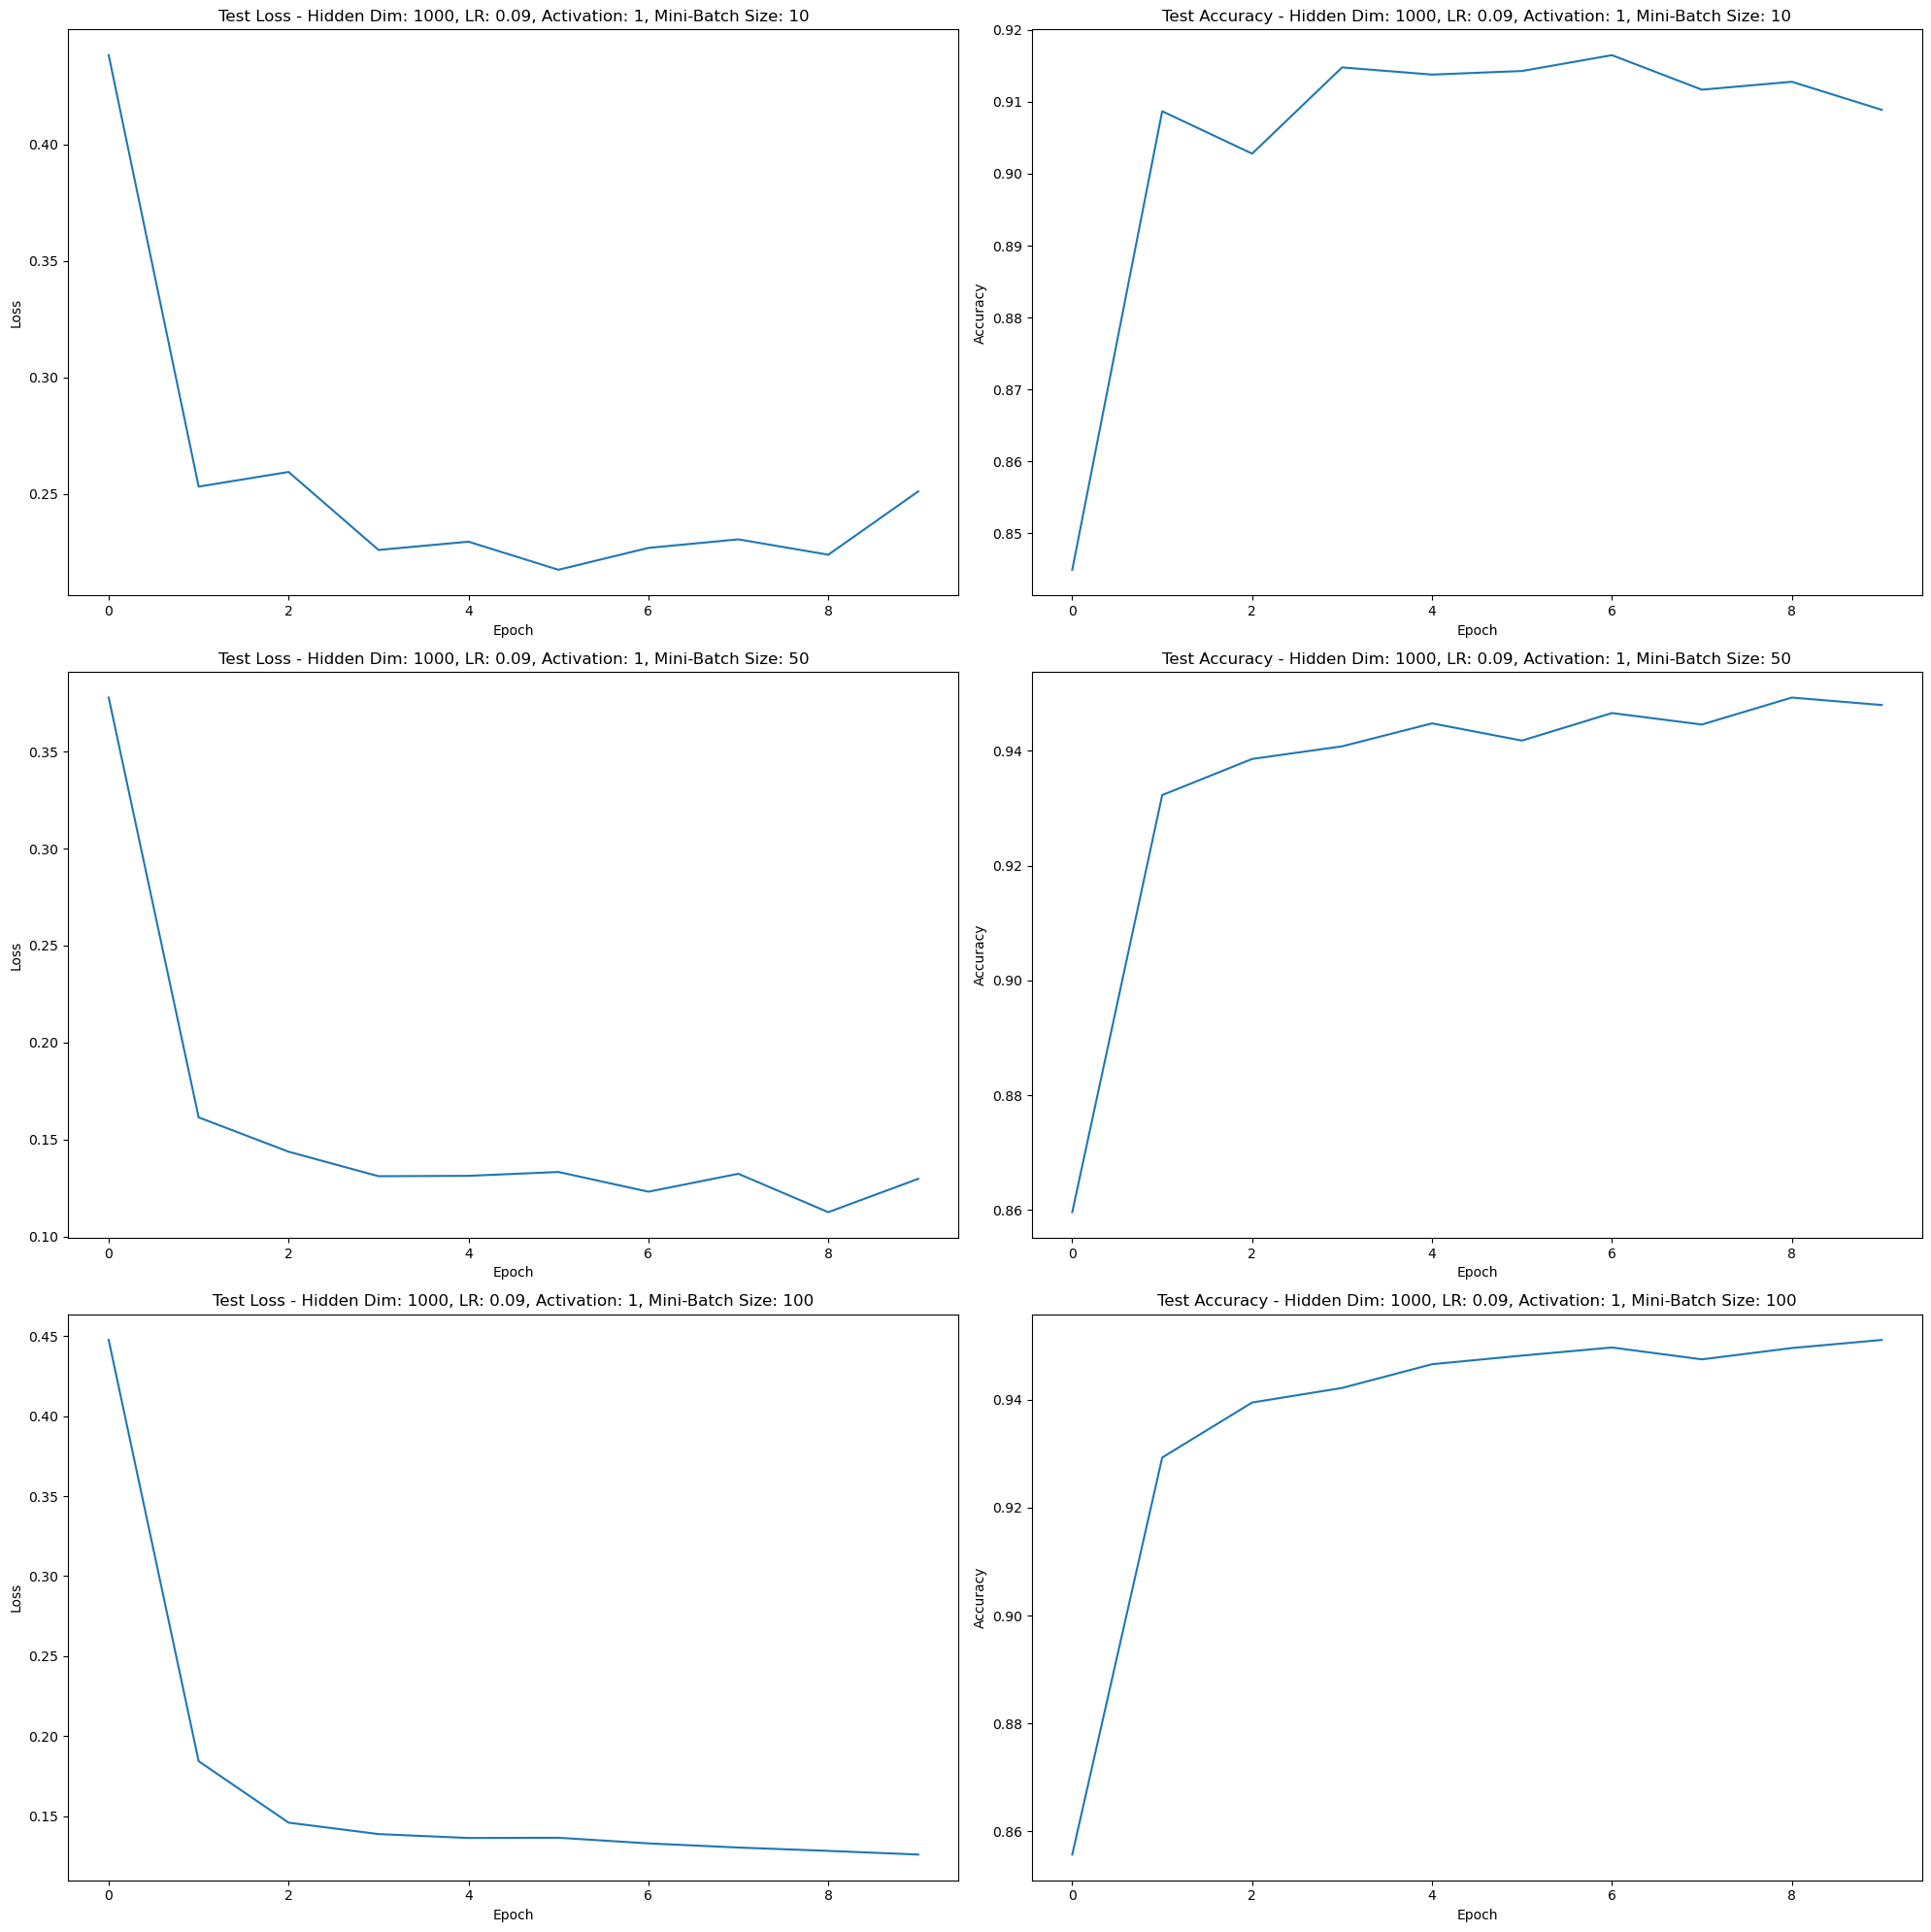

In [10]:
# Find the best mini-batch size wrt to test accuracy 
best_mini_batch_size = None
best_acc = 0
for key in mini_batch_models.keys():
    if mini_batch_models[key].testaccuracy[-1] >= best_acc:
        best_acc = mini_batch_models[key].testaccuracy[-1] 
        best_config_mini_batch = key 
        
print(f"Model with hidden dimension {best_config_mini_batch[0]}, learning rate {best_config_mini_batch[1]}, activation {best_config_mini_batch[2]} and mini-batch size {best_config_mini_batch[3]} has the highest test accuracy of {mini_batch_models[best_config_mini_batch].testaccuracy[-1]:.4f}")

# for each model, plot the train/test loss/accuracy
fig, axs = plt.subplots(len(mini_batch_models), 2, figsize=(20, 20))

# loop through each model and plot the train/test loss/accuracy
for i, ((h, rate, n, size), model) in enumerate(mini_batch_models.items()):
    
    # plot the test loss
    axs[i, 0].plot(model.test_loss)
    axs[i, 0].set_title(f"Test Loss - Hidden Dim: {h}, LR: {rate}, Activation: {n}, Mini-Batch Size: {size}")
    axs[i, 0].set_xlabel("Epoch")
    axs[i, 0].set_ylabel("Loss")
    
    # plot the test accuracy
    axs[i, 1].plot(model.testaccuracy)
    axs[i, 1].set_title(f"Test Accuracy - Hidden Dim: {h}, LR: {rate}, Activation: {n}, Mini-Batch Size: {size}")
    axs[i, 1].set_xlabel("Epoch")
    axs[i, 1].set_ylabel("Accuracy")
    
fig.tight_layout()
fig.savefig("Figure4.png")
fig.show()

In [11]:
# create a df with the training time and test loss-accuracy of the mini batch models
data = []
for key, model in mini_batch_models.items():
    data.append([key[3], model.train_time[-1], model.test_loss[-1], model.testaccuracy[-1]])
df = pd.DataFrame(data, columns = ["Mini-Batch Size", "Training Time (seconds)", "Test Loss", "Test Accuracy"])
print(df)

   Mini-Batch Size  Training Time (seconds)  Test Loss  Test Accuracy
0               10              8823.307301   0.251164         0.9089
1               50              2214.638463   0.129760         0.9480
2              100               991.429990   0.126046         0.9511


In [12]:
# Here we will train the best model so far with the best mini-batch size with different regularization parameters
lamb = [1e-2, 1e-3]
lamb_models = {(best_config_mini_batch[0], best_config_mini_batch[1], best_config_mini_batch[2], best_config_mini_batch[3], lambd): NN(input_dim, best_config_mini_batch[0], output_dim, best_config_mini_batch[1], epochs, activation = best_config_mini_batch[2], batch_size = best_config_mini_batch[3]) for lambd in lamb}

for model in lamb_models.values():
    print("Training model with hidden dimension: ", model.W1.shape[0], "learning rate: ", model.lr, "and activation: ", model.activation)
    model.train(X_train, Y_train, X_test, Y_test)


Training model with hidden dimension:  1000 learning rate:  0.09 and activation:  1
Epoch:  10 Loss:  0.2010854245703035 Accuracy:  0.9338666666666666 Test Loss:  0.20287080888260695 Test Accuracy:  0.9335
Epoch:  20 Loss:  0.14997060521968458 Accuracy:  0.9484166666666667 Test Loss:  0.15393116444682103 Test Accuracy:  0.9456
Epoch:  30 Loss:  0.15256701900793138 Accuracy:  0.9550666666666666 Test Loss:  0.15872830900857887 Test Accuracy:  0.949
Epoch:  40 Loss:  0.12764135387971293 Accuracy:  0.9582833333333334 Test Loss:  0.13504533948314615 Test Accuracy:  0.9515
Epoch:  50 Loss:  0.14515518743883957 Accuracy:  0.9619 Test Loss:  0.15393734163504377 Test Accuracy:  0.954
Epoch:  60 Loss:  0.14013915487855994 Accuracy:  0.9627 Test Loss:  0.14951977379266515 Test Accuracy:  0.9555
Epoch:  70 Loss:  0.11643494736194158 Accuracy:  0.9652666666666667 Test Loss:  0.1268947846734613 Test Accuracy:  0.9568
Epoch:  80 Loss:  0.11983290799634894 Accuracy:  0.9660833333333333 Test Loss:  0.1

In [13]:
#find the model with the highest test accuracy
best_config_lambda = None
best_acc = 0
for key in lamb_models.keys():
    if lamb_models[key].testaccuracy[-1] >= best_acc:
        best_acc = lamb_models[key].testaccuracy[-1]
        best_config_lambda = key

print(f"Model with hidden dimension {best_config_lambda[0]}, learning rate {best_config_lambda[1]}, activation {best_config_lambda[2]}, mini-batch size {best_config_lambda[3]} and regularization parameter {best_config_lambda[4]} has the highest test accuracy of {lamb_models[best_config_lambda].testaccuracy[-1]:.4f}")

Model with hidden dimension 1000, learning rate 0.09, activation 1, mini-batch size 100 and regularization parameter 0.01 has the highest test accuracy of 0.9588


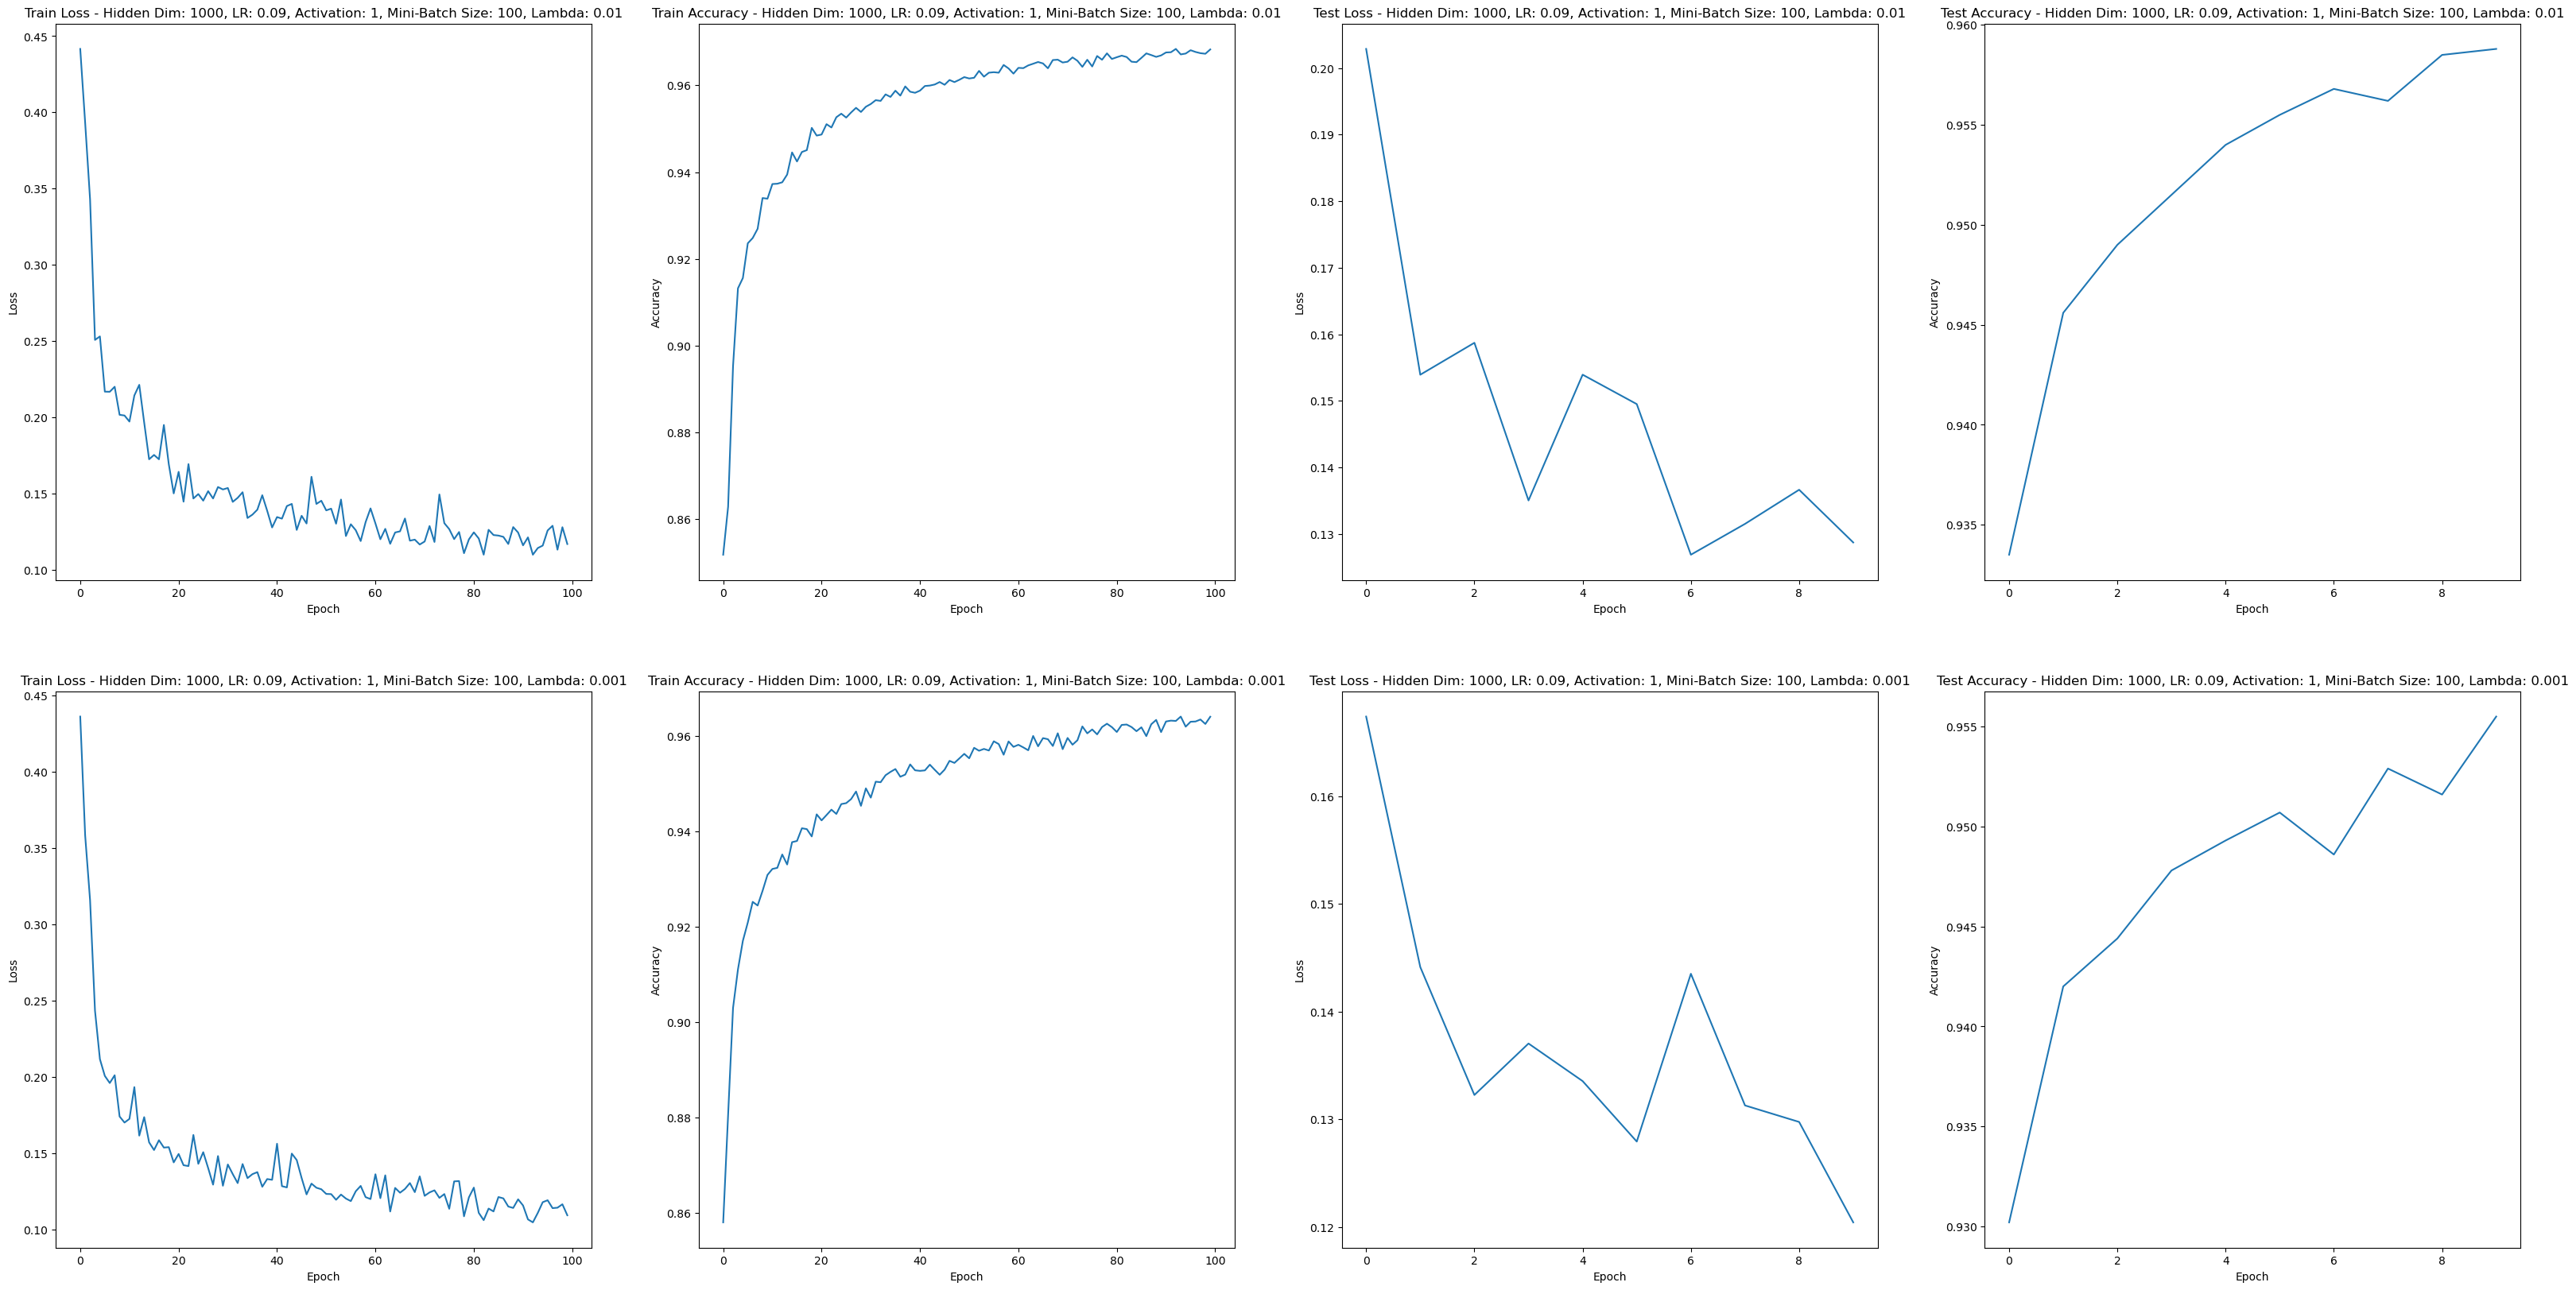

In [14]:
# plot the train test loss/accuracy for each model
fig, axs = plt.subplots(len(lamb_models), 4, figsize=(40, 20))

for i ,(key, model) in enumerate(lamb_models.items()):
    # plot the train loss
    axs[i, 0].plot(model.train_loss)
    axs[i, 0].set_title(f"Train Loss - Hidden Dim: {key[0]}, LR: {key[1]}, Activation: {key[2]}, Mini-Batch Size: {key[3]}, Lambda: {key[4]}")
    axs[i, 0].set_xlabel("Epoch")
    axs[i, 0].set_ylabel("Loss")
    
    # plot the train accuracy
    axs[i, 1].plot(model.trainaccuracy)
    axs[i, 1].set_title(f"Train Accuracy - Hidden Dim: {key[0]}, LR: {key[1]}, Activation: {key[2]}, Mini-Batch Size: {key[3]}, Lambda: {key[4]}")
    axs[i, 1].set_xlabel("Epoch")
    axs[i, 1].set_ylabel("Accuracy")
    
    # plot the test loss
    axs[i, 2].plot(model.test_loss)
    axs[i, 2].set_title(f"Test Loss - Hidden Dim: {key[0]}, LR: {key[1]}, Activation: {key[2]}, Mini-Batch Size: {key[3]}, Lambda: {key[4]}")
    axs[i, 2].set_xlabel("Epoch")
    axs[i, 2].set_ylabel("Loss")
    
    # plot the test accuracy
    axs[i, 3].plot(model.testaccuracy)
    axs[i, 3].set_title(f"Test Accuracy - Hidden Dim: {key[0]}, LR: {key[1]}, Activation: {key[2]}, Mini-Batch Size: {key[3]}, Lambda: {key[4]}")
    axs[i, 3].set_xlabel("Epoch")
    axs[i, 3].set_ylabel("Accuracy")
fig.savefig("Figure5.png")

In [15]:
# create a df with the training time and train/test loss-accuracy of the mini batch models
data = []
for key, model in lamb_models.items():
    data.append([key[4], model.train_time[-1], model.train_loss[-1], model.trainaccuracy[-1], model.test_loss[-1], model.testaccuracy[-1]])
    df = pd.DataFrame(data, columns = ["Lambda", "Training Time (seconds)", "Train Loss", "Train Accuracy", "Test Loss", "Test Accuracy"])
print(df)

   Lambda  Training Time (seconds)  Train Loss  Train Accuracy  Test Loss   
0   0.010              1844.547873    0.116757        0.968283   0.128735  \
1   0.001              1301.783485    0.109335        0.964067   0.120414   

   Test Accuracy  
0         0.9588  
1         0.9555  
